In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from modAL.models import ActiveLearner
from modAL.models import ActiveLearner, Committee
from modAL.disagreement import vote_entropy_sampling
from modAL.disagreement import vote_entropy
from modAL.disagreement import KL_max_disagreement
from modAL.uncertainty import classifier_uncertainty
from copy import deepcopy
# Set our RNG seed for reproducibility.
RANDOM_STATE_SEED = 1
np.random.seed(RANDOM_STATE_SEED)

In [2]:
dataset = pd.read_csv("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/glass.data", header = None)
dataset.drop(columns = 0, inplace = True)

In [3]:
X_full = dataset.iloc[:, 0:dataset.shape[1]-1]
y_full = dataset.iloc[:, -1]
X_full = X_full.to_numpy()
y_full = y_full.to_numpy()
n_labeled_examples = X_full.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=round((len(X_full))*0.1))

In [4]:
y_full

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [5]:
N_QUERIES_10 = round((len(X_full))*0.1)
N_QUERIES_20 = round((len(X_full))*0.2)
N_QUERIES_30 = round((len(X_full))*0.3)
N_QUERIES_40 = round((len(X_full))*0.4)

In [6]:
n_initial = round(len(X_full)*0.1)
train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)

# Pool Based

# 10% Additional Labels

Initial prediction accuracy using KL Divergence: 0.658879
Row no. 5 queried, new accuracy: 0.654206
Row no. 100 queried, new accuracy: 0.677570
Row no. 167 queried, new accuracy: 0.682243
Row no. 117 queried, new accuracy: 0.696262
Row no. 169 queried, new accuracy: 0.710280
Row no. 145 queried, new accuracy: 0.747664
Row no. 12 queried, new accuracy: 0.738318
Row no. 72 queried, new accuracy: 0.742991
Row no. 55 queried, new accuracy: 0.733645
Row no. 89 queried, new accuracy: 0.738318
Row no. 72 queried, new accuracy: 0.728972
Row no. 78 queried, new accuracy: 0.700935
Row no. 94 queried, new accuracy: 0.700935
Row no. 146 queried, new accuracy: 0.733645
Row no. 167 queried, new accuracy: 0.757009
Row no. 103 queried, new accuracy: 0.742991
Row no. 160 queried, new accuracy: 0.752336
Row no. 93 queried, new accuracy: 0.738318
Row no. 132 queried, new accuracy: 0.738318
Row no. 135 queried, new accuracy: 0.728972
Row no. 147 queried, new accuracy: 0.728972


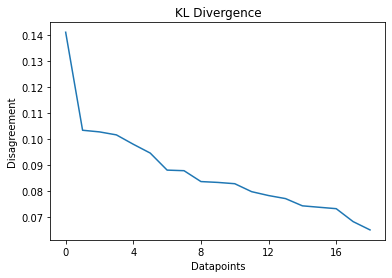

Initial prediction accuracy using vote entropy: 0.644860
Accuracy after query 189: 0.6682
Accuracy after query 181: 0.6636
Accuracy after query 9: 0.6869
Accuracy after query 14: 0.6822
Accuracy after query 22: 0.6822
Accuracy after query 24: 0.6822
Accuracy after query 62: 0.6776
Accuracy after query 100: 0.7009
Accuracy after query 124: 0.6963
Accuracy after query 127: 0.7150
Accuracy after query 131: 0.7243
Accuracy after query 142: 0.7243
Accuracy after query 145: 0.7150
Accuracy after query 167: 0.7523
Accuracy after query 172: 0.7383
Accuracy after query 173: 0.7570
Accuracy after query 173: 0.7523
Accuracy after query 2: 0.7523
Accuracy after query 3: 0.7523
Accuracy after query 4: 0.7336
Accuracy after query 5: 0.7477


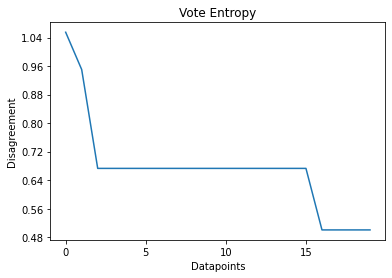

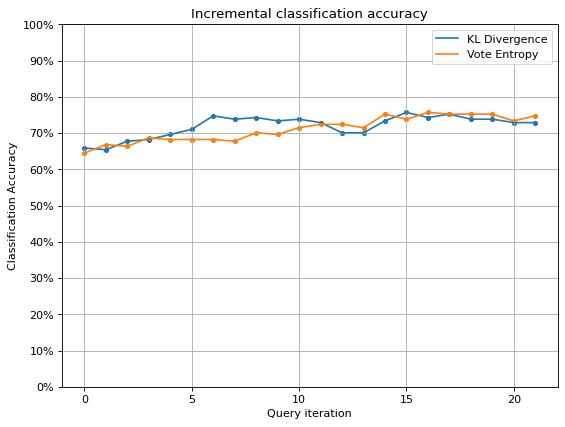

In [9]:
# 10% Additional Labels
n_members = 5
learner_list = list()

# n_initial = round(len(X_full)*0.1)
# train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
for member_idx in range(n_members):
    # initial training data
#     n_initial = round(len(X_raw)*0.1)
#     train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

committee_KL = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_KL = committee_KL.score(X_full, y_full)
print('Initial prediction accuracy using KL Divergence: %f' % unqueried_score_KL)

performance_history_KL_10 = [unqueried_score_KL]
X_pool = deepcopy(X_remaining)
y_pool = deepcopy(y_remaining)
# query by committee
dicti = {}
for idx in range(N_QUERIES_10):
    query_instance = committee_KL.query(X_pool)
    query_idx = query_instance.argmax()
    dict1 = {query_idx:query_instance[query_idx]}
    dicti.update(dict1)
    query_idx = np.array((query_idx))
    committee_KL.teach(
        X = X_pool[query_idx].reshape(1, -1),
        y = y_pool[query_idx].reshape(1, )
    )
    new_score = committee_KL.score(X_full, y_full)
    performance_history_KL_10.append(new_score)
    print('Row no. %d queried, new accuracy: %f' % (query_idx, new_score))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis = 0)
    y_pool = np.delete(y_pool, query_idx)

sort_dict = sorted(dicti.items(), key=lambda x: x[1], reverse=True)

import collections

dicti = collections.OrderedDict(sort_dict)
 # Create list
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
ax.plot(list(dicti.values()))
ax.set_xlabel("Datapoints")
ax.set_ylabel("Disagreement")
ax.set_title("KL Divergence")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/KL_10.png")
plt.show()  


n_members = 5
learner_list = list()

# n_initial = round(len(X_full)*0.1)
# train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
for member_idx in range(n_members):
    # initial training data
#     n_initial = round(len(X_raw)*0.1)
#     train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=vote_entropy)

unqueried_score_entropy = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

performance_history_entropy_10 = [unqueried_score_entropy]
values = committee_entropy.query(X_remaining)
# print(np.argmax(values))
# print(values)
# print(values[np.argmax(values)])
dicti = {}
for i in range(N_QUERIES_10):
    top_index = np.argmax(values)
    top_value = values[top_index]
    X, y = X_remaining[top_index].reshape(1,-1), y_remaining[top_index].reshape(1,)
    committee_entropy.teach(X=X, y=y)
    model_accuracy = committee_entropy.score(X_full, y_full)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=top_index + 1, acc=model_accuracy))
    performance_history_entropy_10.append(model_accuracy)
    values = np.delete(values, top_index)
    dict1 = {top_index:top_value}
    dicti.update(dict1)
    

sort_dict = sorted(dicti.items(), key=lambda x: x[1], reverse=True)

import collections

dicti = collections.OrderedDict(sort_dict)
 # Create list
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
ax.plot(list(dicti.values()))
ax.set_xlabel("Datapoints")
ax.set_ylabel("Disagreement")
ax.set_title("Vote Entropy")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/VE_10.png")
plt.show()  



%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_10, label = "KL Divergence")
ax.plot(performance_history_entropy_10, label = "Vote Entropy")
ax.scatter(range(len(performance_history_KL_10)), performance_history_KL_10, s=13)
ax.scatter(range(len(performance_history_entropy_10)), performance_history_entropy_10, s=13)
leg = ax.legend()
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/qbc_10.png")

plt.show()

# 20% Additional Labels

Initial prediction accuracy using KL Divergence: 0.654206
Row no. 120 queried, new accuracy: 0.644860
Row no. 175 queried, new accuracy: 0.644860
Row no. 123 queried, new accuracy: 0.644860
Row no. 97 queried, new accuracy: 0.644860
Row no. 160 queried, new accuracy: 0.668224
Row no. 122 queried, new accuracy: 0.663551
Row no. 138 queried, new accuracy: 0.668224
Row no. 95 queried, new accuracy: 0.644860
Row no. 137 queried, new accuracy: 0.635514
Row no. 95 queried, new accuracy: 0.649533
Row no. 136 queried, new accuracy: 0.649533
Row no. 170 queried, new accuracy: 0.644860
Row no. 143 queried, new accuracy: 0.644860
Row no. 130 queried, new accuracy: 0.649533
Row no. 57 queried, new accuracy: 0.654206
Row no. 125 queried, new accuracy: 0.658879
Row no. 32 queried, new accuracy: 0.724299
Row no. 174 queried, new accuracy: 0.733645
Row no. 121 queried, new accuracy: 0.733645
Row no. 52 queried, new accuracy: 0.728972
Row no. 91 queried, new accuracy: 0.728972
Row no. 99 queried, new a

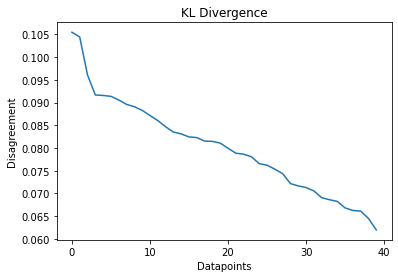

Initial prediction accuracy using vote entropy: 0.663551
Accuracy after query 139: 0.6168
Accuracy after query 35: 0.6495
Accuracy after query 129: 0.6308
Accuracy after query 168: 0.6589
Accuracy after query 173: 0.6589
Accuracy after query 184: 0.6729
Accuracy after query 4: 0.6869
Accuracy after query 8: 0.6822
Accuracy after query 11: 0.6916
Accuracy after query 12: 0.6963
Accuracy after query 25: 0.7056
Accuracy after query 49: 0.7009
Accuracy after query 98: 0.7243
Accuracy after query 109: 0.7383
Accuracy after query 112: 0.7290
Accuracy after query 117: 0.7477
Accuracy after query 5: 0.7523
Accuracy after query 17: 0.7430
Accuracy after query 21: 0.7477
Accuracy after query 21: 0.7523
Accuracy after query 30: 0.7477
Accuracy after query 38: 0.7523
Accuracy after query 43: 0.7477
Accuracy after query 52: 0.7430
Accuracy after query 101: 0.7477
Accuracy after query 103: 0.7477
Accuracy after query 112: 0.7336
Accuracy after query 127: 0.7383
Accuracy after query 128: 0.7430
Accur

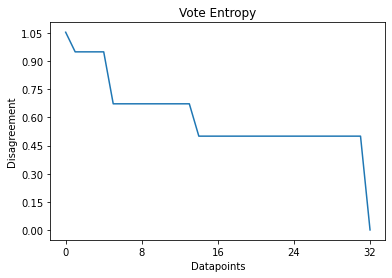

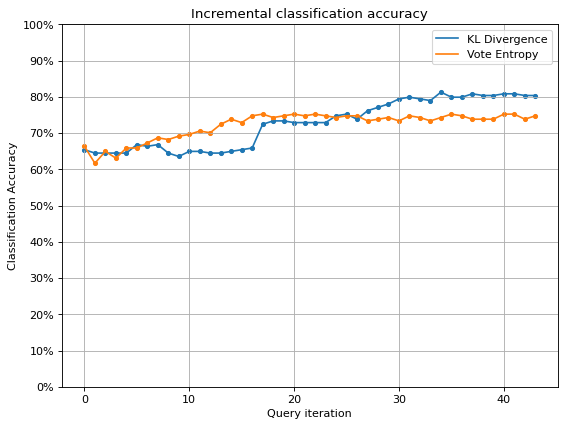

In [10]:
# 20% Additional Labels
n_members = 5
learner_list = list()

# n_initial = round(len(X_full)*0.1)
# train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
for member_idx in range(n_members):
    # initial training data
#     n_initial = round(len(X_raw)*0.1)
#     train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

committee_KL = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_KL = committee_KL.score(X_full, y_full)
print('Initial prediction accuracy using KL Divergence: %f' % unqueried_score_KL)

performance_history_KL_20 = [unqueried_score_KL]
X_pool = deepcopy(X_remaining)
y_pool = deepcopy(y_remaining)
# query by committee
dicti = {}
for idx in range(N_QUERIES_20):
    query_instance = committee_KL.query(X_pool)
    query_idx = query_instance.argmax()
    dict1 = {query_idx:query_instance[query_idx]}
    dicti.update(dict1)
    query_idx = np.array((query_idx))
    committee_KL.teach(
        X = X_pool[query_idx].reshape(1, -1),
        y = y_pool[query_idx].reshape(1, )
    )
    new_score = committee_KL.score(X_full, y_full)
    performance_history_KL_20.append(new_score)
    print('Row no. %d queried, new accuracy: %f' % (query_idx, new_score))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis = 0)
    y_pool = np.delete(y_pool, query_idx)

sort_dict = sorted(dicti.items(), key=lambda x: x[1], reverse=True)

import collections

dicti = collections.OrderedDict(sort_dict)
 # Create list
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
ax.plot(list(dicti.values()))
ax.set_xlabel("Datapoints")
ax.set_ylabel("Disagreement")
ax.set_title("KL Divergence")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/KL_20.png")
plt.show()  


n_members = 5
learner_list = list()

# n_initial = round(len(X_full)*0.1)
# train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
for member_idx in range(n_members):
    # initial training data
#     n_initial = round(len(X_raw)*0.1)
#     train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=vote_entropy)

unqueried_score_entropy = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

performance_history_entropy_20 = [unqueried_score_entropy]
values = committee_entropy.query(X_remaining)
# print(np.argmax(values))
# print(values)
# print(values[np.argmax(values)])
dicti = {}
for i in range(N_QUERIES_20):
    top_index = np.argmax(values)
    top_value = values[top_index]
    X, y = X_remaining[top_index].reshape(1,-1), y_remaining[top_index].reshape(1,)
    committee_entropy.teach(X=X, y=y)
    model_accuracy = committee_entropy.score(X_full, y_full)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=top_index + 1, acc=model_accuracy))
    performance_history_entropy_20.append(model_accuracy)
    values = np.delete(values, top_index)
    dict1 = {top_index:top_value}
    dicti.update(dict1)
    

sort_dict = sorted(dicti.items(), key=lambda x: x[1], reverse=True)

import collections

dicti = collections.OrderedDict(sort_dict)
 # Create list
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
ax.plot(list(dicti.values()))
ax.set_xlabel("Datapoints")
ax.set_ylabel("Disagreement")
ax.set_title("Vote Entropy")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/VE_20.png")
plt.show()  



%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_20, label = "KL Divergence")
ax.plot(performance_history_entropy_20, label = "Vote Entropy")
ax.scatter(range(len(performance_history_KL_20)), performance_history_KL_20, s=13)
ax.scatter(range(len(performance_history_entropy_20)), performance_history_entropy_20, s=13)
leg = ax.legend()
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/qbc_20.png")

plt.show()

# 30%Additional Labels

Initial prediction accuracy using KL Divergence: 0.654206
Row no. 115 queried, new accuracy: 0.663551
Row no. 137 queried, new accuracy: 0.635514
Row no. 57 queried, new accuracy: 0.635514
Row no. 184 queried, new accuracy: 0.672897
Row no. 172 queried, new accuracy: 0.663551
Row no. 31 queried, new accuracy: 0.691589
Row no. 81 queried, new accuracy: 0.686916
Row no. 94 queried, new accuracy: 0.682243
Row no. 87 queried, new accuracy: 0.672897
Row no. 159 queried, new accuracy: 0.672897
Row no. 51 queried, new accuracy: 0.686916
Row no. 25 queried, new accuracy: 0.696262
Row no. 58 queried, new accuracy: 0.686916
Row no. 41 queried, new accuracy: 0.686916
Row no. 168 queried, new accuracy: 0.691589
Row no. 107 queried, new accuracy: 0.691589
Row no. 111 queried, new accuracy: 0.714953
Row no. 145 queried, new accuracy: 0.738318
Row no. 18 queried, new accuracy: 0.757009
Row no. 129 queried, new accuracy: 0.752336
Row no. 45 queried, new accuracy: 0.752336
Row no. 129 queried, new accu

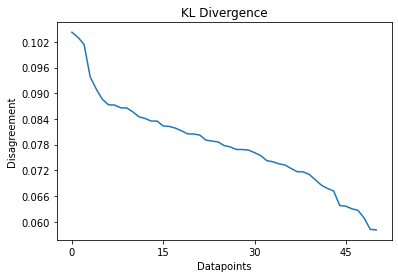

Initial prediction accuracy using vote entropy: 0.668224
Accuracy after query 189: 0.6636
Accuracy after query 2: 0.6682
Accuracy after query 8: 0.6682
Accuracy after query 11: 0.6682
Accuracy after query 12: 0.6822
Accuracy after query 18: 0.6822
Accuracy after query 22: 0.6869
Accuracy after query 43: 0.6822
Accuracy after query 59: 0.6682
Accuracy after query 96: 0.7150
Accuracy after query 96: 0.7150
Accuracy after query 113: 0.7103
Accuracy after query 123: 0.7243
Accuracy after query 139: 0.7477
Accuracy after query 142: 0.7523
Accuracy after query 171: 0.7617
Accuracy after query 3: 0.7617
Accuracy after query 6: 0.7617
Accuracy after query 17: 0.7523
Accuracy after query 18: 0.7383
Accuracy after query 19: 0.7477
Accuracy after query 24: 0.7523
Accuracy after query 24: 0.7430
Accuracy after query 41: 0.7430
Accuracy after query 73: 0.7383
Accuracy after query 87: 0.7664
Accuracy after query 89: 0.7336
Accuracy after query 98: 0.7383
Accuracy after query 115: 0.7523
Accuracy aft

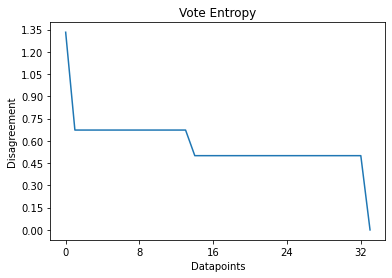

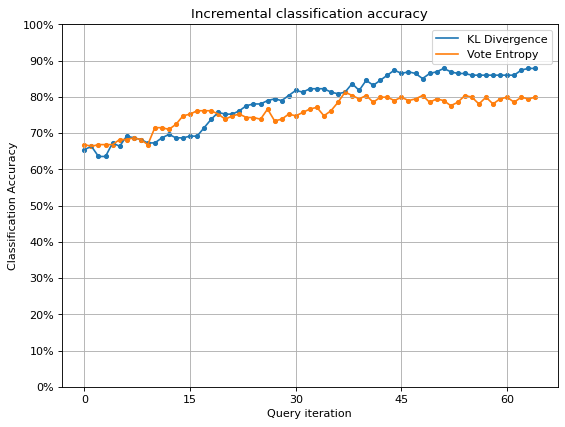

In [12]:
# 20% Additional Labels
n_members = 5
learner_list = list()

# n_initial = round(len(X_full)*0.1)
# train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
for member_idx in range(n_members):
    # initial training data
#     n_initial = round(len(X_raw)*0.1)
#     train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

committee_KL = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_KL = committee_KL.score(X_full, y_full)
print('Initial prediction accuracy using KL Divergence: %f' % unqueried_score_KL)

performance_history_KL_30 = [unqueried_score_KL]
X_pool = deepcopy(X_remaining)
y_pool = deepcopy(y_remaining)
# query by committee
dicti = {}
for idx in range(N_QUERIES_30):
    query_instance = committee_KL.query(X_pool)
    query_idx = query_instance.argmax()
    dict1 = {query_idx:query_instance[query_idx]}
    dicti.update(dict1)
    query_idx = np.array((query_idx))
    committee_KL.teach(
        X = X_pool[query_idx].reshape(1, -1),
        y = y_pool[query_idx].reshape(1, )
    )
    new_score = committee_KL.score(X_full, y_full)
    performance_history_KL_30.append(new_score)
    print('Row no. %d queried, new accuracy: %f' % (query_idx, new_score))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis = 0)
    y_pool = np.delete(y_pool, query_idx)

sort_dict = sorted(dicti.items(), key=lambda x: x[1], reverse=True)

import collections

dicti = collections.OrderedDict(sort_dict)
 # Create list
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
ax.plot(list(dicti.values()))
ax.set_xlabel("Datapoints")
ax.set_ylabel("Disagreement")
ax.set_title("KL Divergence")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/KL_30.png")
plt.show()  


n_members = 5
learner_list = list()

# n_initial = round(len(X_full)*0.1)
# train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
for member_idx in range(n_members):
    # initial training data
#     n_initial = round(len(X_raw)*0.1)
#     train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=vote_entropy)

unqueried_score_entropy = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

performance_history_entropy_30 = [unqueried_score_entropy]
values = committee_entropy.query(X_remaining)
# print(np.argmax(values))
# print(values)
# print(values[np.argmax(values)])
dicti = {}
for i in range(N_QUERIES_30):
    top_index = np.argmax(values)
    top_value = values[top_index]
    X, y = X_remaining[top_index].reshape(1,-1), y_remaining[top_index].reshape(1,)
    committee_entropy.teach(X=X, y=y)
    model_accuracy = committee_entropy.score(X_full, y_full)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=top_index + 1, acc=model_accuracy))
    performance_history_entropy_30.append(model_accuracy)
    values = np.delete(values, top_index)
    dict1 = {top_index:top_value}
    dicti.update(dict1)
    

sort_dict = sorted(dicti.items(), key=lambda x: x[1], reverse=True)

import collections

dicti = collections.OrderedDict(sort_dict)
 # Create list
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
ax.plot(list(dicti.values()))
ax.set_xlabel("Datapoints")
ax.set_ylabel("Disagreement")
ax.set_title("Vote Entropy")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/VE_30.png")
plt.show()  



%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_30, label = "KL Divergence")
ax.plot(performance_history_entropy_30, label = "Vote Entropy")
ax.scatter(range(len(performance_history_KL_30)), performance_history_KL_30, s=13)
ax.scatter(range(len(performance_history_entropy_30)), performance_history_entropy_30, s=13)
leg = ax.legend()
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/qbc_30.png")

plt.show()

# 40%Additional Labels

Initial prediction accuracy using KL Divergence: 0.663551
Row no. 159 queried, new accuracy: 0.654206
Row no. 2 queried, new accuracy: 0.626168
Row no. 92 queried, new accuracy: 0.635514
Row no. 42 queried, new accuracy: 0.658879
Row no. 134 queried, new accuracy: 0.691589
Row no. 98 queried, new accuracy: 0.668224
Row no. 76 queried, new accuracy: 0.654206
Row no. 151 queried, new accuracy: 0.663551
Row no. 115 queried, new accuracy: 0.677570
Row no. 103 queried, new accuracy: 0.672897
Row no. 170 queried, new accuracy: 0.686916
Row no. 96 queried, new accuracy: 0.663551
Row no. 40 queried, new accuracy: 0.668224
Row no. 134 queried, new accuracy: 0.658879
Row no. 44 queried, new accuracy: 0.668224
Row no. 145 queried, new accuracy: 0.677570
Row no. 40 queried, new accuracy: 0.691589
Row no. 83 queried, new accuracy: 0.677570
Row no. 105 queried, new accuracy: 0.672897
Row no. 90 queried, new accuracy: 0.677570
Row no. 16 queried, new accuracy: 0.682243
Row no. 87 queried, new accurac

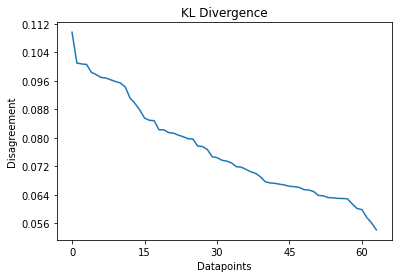

Initial prediction accuracy using vote entropy: 0.682243
Accuracy after query 35: 0.6542
Accuracy after query 138: 0.6869
Accuracy after query 4: 0.6729
Accuracy after query 12: 0.6822
Accuracy after query 20: 0.6822
Accuracy after query 24: 0.6869
Accuracy after query 24: 0.6869
Accuracy after query 99: 0.7196
Accuracy after query 120: 0.7103
Accuracy after query 126: 0.7009
Accuracy after query 142: 0.7056
Accuracy after query 146: 0.7150
Accuracy after query 153: 0.7243
Accuracy after query 158: 0.7570
Accuracy after query 160: 0.7056
Accuracy after query 173: 0.7523
Accuracy after query 5: 0.7570
Accuracy after query 7: 0.7664
Accuracy after query 19: 0.7336
Accuracy after query 40: 0.7477
Accuracy after query 45: 0.7477
Accuracy after query 55: 0.7523
Accuracy after query 79: 0.7523
Accuracy after query 95: 0.7757
Accuracy after query 102: 0.7617
Accuracy after query 105: 0.7804
Accuracy after query 105: 0.7710
Accuracy after query 105: 0.7710
Accuracy after query 110: 0.7757
Accu

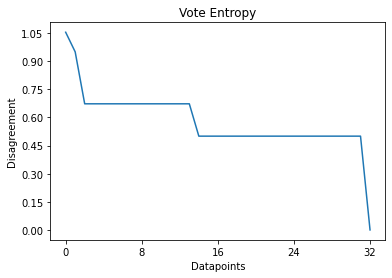

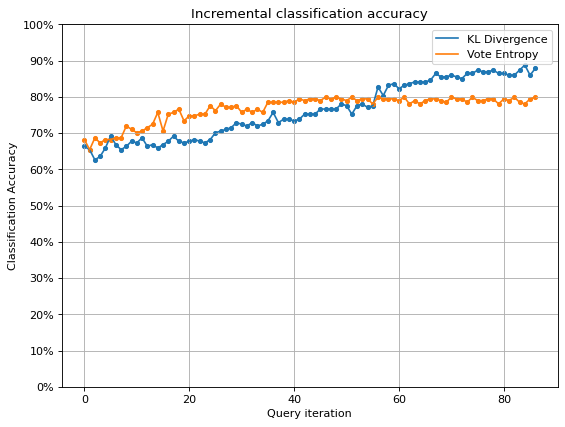

In [13]:
# 20% Additional Labels
n_members = 5
learner_list = list()

# n_initial = round(len(X_full)*0.1)
# train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
for member_idx in range(n_members):
    # initial training data
#     n_initial = round(len(X_raw)*0.1)
#     train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

committee_KL = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_KL = committee_KL.score(X_full, y_full)
print('Initial prediction accuracy using KL Divergence: %f' % unqueried_score_KL)

performance_history_KL_40 = [unqueried_score_KL]
X_pool = deepcopy(X_remaining)
y_pool = deepcopy(y_remaining)
# query by committee
dicti = {}
for idx in range(N_QUERIES_40):
    query_instance = committee_KL.query(X_pool)
    query_idx = query_instance.argmax()
    dict1 = {query_idx:query_instance[query_idx]}
    dicti.update(dict1)
    query_idx = np.array((query_idx))
    committee_KL.teach(
        X = X_pool[query_idx].reshape(1, -1),
        y = y_pool[query_idx].reshape(1, )
    )
    new_score = committee_KL.score(X_full, y_full)
    performance_history_KL_40.append(new_score)
    print('Row no. %d queried, new accuracy: %f' % (query_idx, new_score))
    # remove queried instance from pool
    X_pool = np.delete(X_pool, query_idx, axis = 0)
    y_pool = np.delete(y_pool, query_idx)

sort_dict = sorted(dicti.items(), key=lambda x: x[1], reverse=True)

import collections

dicti = collections.OrderedDict(sort_dict)
 # Create list
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
ax.plot(list(dicti.values()))
ax.set_xlabel("Datapoints")
ax.set_ylabel("Disagreement")
ax.set_title("KL Divergence")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/KL_40.png")
plt.show()  


n_members = 5
learner_list = list()

# n_initial = round(len(X_full)*0.1)
# train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
for member_idx in range(n_members):
    # initial training data
#     n_initial = round(len(X_raw)*0.1)
#     train_idx = np.random.choice(range(X_full.shape[0]), size = n_initial, replace=False)
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=vote_entropy)

unqueried_score_entropy = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

performance_history_entropy_40 = [unqueried_score_entropy]
values = committee_entropy.query(X_remaining)
# print(np.argmax(values))
# print(values)
# print(values[np.argmax(values)])
dicti = {}
for i in range(N_QUERIES_40):
    top_index = np.argmax(values)
    top_value = values[top_index]
    X, y = X_remaining[top_index].reshape(1,-1), y_remaining[top_index].reshape(1,)
    committee_entropy.teach(X=X, y=y)
    model_accuracy = committee_entropy.score(X_full, y_full)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=top_index + 1, acc=model_accuracy))
    performance_history_entropy_40.append(model_accuracy)
    values = np.delete(values, top_index)
    dict1 = {top_index:top_value}
    dicti.update(dict1)
    

sort_dict = sorted(dicti.items(), key=lambda x: x[1], reverse=True)

import collections

dicti = collections.OrderedDict(sort_dict)
 # Create list
from matplotlib.pyplot import figure
fig, ax = plt.subplots()
ax.plot(list(dicti.values()))
ax.set_xlabel("Datapoints")
ax.set_ylabel("Disagreement")
ax.set_title("Vote Entropy")
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/VE_40.png")
plt.show()  



%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_40, label = "KL Divergence")
ax.plot(performance_history_entropy_40, label = "Vote Entropy")
ax.scatter(range(len(performance_history_KL_40)), performance_history_KL_40, s=13)
ax.scatter(range(len(performance_history_entropy_40)), performance_history_entropy_40, s=13)
leg = ax.legend()
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/qbc_40.png")

plt.show()

In [14]:
from copy import deepcopy
KL_10 = deepcopy(performance_history_KL_10)
KL_20 = deepcopy(performance_history_KL_20)
KL_30 = deepcopy(performance_history_KL_30)
KL_40 = deepcopy(performance_history_KL_40)
entropy_10 = deepcopy(performance_history_entropy_10)
entropy_20 = deepcopy(performance_history_entropy_20)
entropy_30 = deepcopy(performance_history_entropy_30)
entropy_40 = deepcopy(performance_history_entropy_40)

# Part 4

Initial prediction accuracy using vote entropy: 0.682243
Row no. 130 queried, new accuracy: 0.649533
Row no. 120 queried, new accuracy: 0.640187
Row no. 178 queried, new accuracy: 0.635514
Row no. 149 queried, new accuracy: 0.649533
Row no. 50 queried, new accuracy: 0.668224
Row no. 53 queried, new accuracy: 0.705607
Row no. 27 queried, new accuracy: 0.700935
Row no. 150 queried, new accuracy: 0.705607
Row no. 118 queried, new accuracy: 0.705607
Row no. 170 queried, new accuracy: 0.724299
Row no. 96 queried, new accuracy: 0.733645
Row no. 153 queried, new accuracy: 0.747664
Row no. 158 queried, new accuracy: 0.742991
Row no. 96 queried, new accuracy: 0.766355
Row no. 85 queried, new accuracy: 0.757009
Row no. 124 queried, new accuracy: 0.761682
Row no. 131 queried, new accuracy: 0.771028
Row no. 138 queried, new accuracy: 0.775701
Row no. 19 queried, new accuracy: 0.799065
Row no. 143 queried, new accuracy: 0.808411
Row no. 39 queried, new accuracy: 0.799065


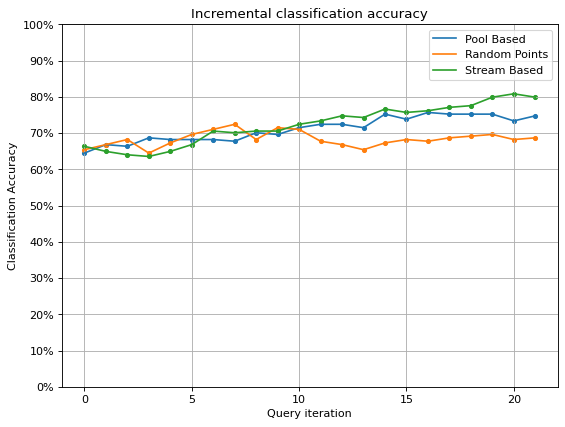

In [46]:
# 10% Additional Labels
# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=vote_entropy)

# unqueried_score_random = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

# X_remaining = np.delete(X_full, train_idx, axis=0)
# y_remaining = np.delete(y_full, train_idx)

# performance_history_random_10 = [unqueried_score_random]
# for i in range(N_QUERIES_10):
#     random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
#     X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
#     committee_entropy.teach(X=X, y=y)
#     model_accuracy = committee_entropy.score(X_full, y_full)
#     X_remaining = np.delete(X_remaining, random, axis = 0)
#     y_remaining = np.delete(y_remaining, random)
#     print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
#     performance_history_random_10.append(model_accuracy)


n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=vote_entropy)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_stream_10 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if vote_entropy(committee_entropy, X_stream[stream_idx].reshape(1, -1)) > 0.48:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_stream_10.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_10:
            break
    
    
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_entropy_10, label = "Pool Based")
ax.plot(performance_history_random_10, label = "Random Points")
ax.plot(performance_history_stream_10, label = "Stream Based")
leg = ax.legend()
ax.scatter(range(len(performance_history_entropy_10)), performance_history_entropy_10, s=13)
ax.scatter(range(len(performance_history_random_10)), performance_history_random_10, s=13)
ax.scatter(range(len(performance_history_stream_10)), performance_history_stream_10, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_10.png")
plt.show()


In [ ]:
# # 10% Additional Labels
# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=vote_entropy)

# unqueried_score_random = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

# X_remaining = np.delete(X_full, train_idx, axis=0)
# y_remaining = np.delete(y_full, train_idx)

# performance_history_random_10 = [unqueried_score_random]
# for i in range(N_QUERIES_10):
#     random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
#     X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
#     committee_entropy.teach(X=X, y=y)
#     model_accuracy = committee_entropy.score(X_full, y_full)
#     X_remaining = np.delete(X_remaining, random, axis = 0)
#     y_remaining = np.delete(y_remaining, random)
#     print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
#     performance_history_random_10.append(model_accuracy)


# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=vote_entropy)

# unqueried_score_stream = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

# X_stream = np.delete(X_full, train_idx, axis=0)
# y_stream = np.delete(y_full, train_idx)


# stream1 = []

# performance_history_stream_10 = [unqueried_score_stream]
# for index in range(N_QUERIES_10):
#     stream_idx = np.random.choice(range(len(X_stream)))
#     if classifier_uncertainty(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.4:
#         committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
#         new_score = committee_entropy.score(X_full, y_full)
#         X_stream = np.delete(X_stream, stream_idx, axis = 0)
#         y_stream = np.delete(y_stream, stream_idx)
#         performance_history_stream_10.append(new_score)
#         print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
    
    
    
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

# ax.plot(performance_history_entropy_10, label = "Pool Based")
# ax.plot(performance_history_random_10, label = "Random Points")
# ax.plot(performance_history_stream_10, label = "Stream Based")
# leg = ax.legend()
# ax.scatter(range(len(performance_history_entropy_10)), performance_history_entropy_10, s=13)
# ax.scatter(range(len(performance_history_random_10)), performance_history_random_10, s=13)
# ax.scatter(range(len(performance_history_stream_10)), performance_history_stream_10, s=13)
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
# ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

# ax.set_ylim(bottom=0, top=1)
# ax.grid(True)

# ax.set_title('Incremental classification accuracy')
# ax.set_xlabel('Query iteration')
# ax.set_ylabel('Classification Accuracy')

# plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_10.png")
# plt.show()


In [ ]:
# # 10% Additional Labels
# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=vote_entropy)

# unqueried_score_random = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

# X_remaining = np.delete(X_full, train_idx, axis=0)
# y_remaining = np.delete(y_full, train_idx)

# performance_history_random_10 = [unqueried_score_random]
# for i in range(N_QUERIES_10):
#     random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
#     X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
#     committee_entropy.teach(X=X, y=y)
#     model_accuracy = committee_entropy.score(X_full, y_full)
#     X_remaining = np.delete(X_remaining, random, axis = 0)
#     y_remaining = np.delete(y_remaining, random)
#     print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
#     performance_history_random_10.append(model_accuracy)


# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=vote_entropy)

# unqueried_score_stream = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

# X_stream = np.delete(X_full, train_idx, axis=0)
# y_stream = np.delete(y_full, train_idx)


# stream1 = []

# performance_history_stream_10 = [unqueried_score_stream]
# for index in range(N_QUERIES_10):
#     stream_idx = np.random.choice(range(len(X_stream)))
#     if classifier_uncertainty(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.4:
#         committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
#         new_score = committee_entropy.score(X_full, y_full)
#         X_stream = np.delete(X_stream, stream_idx, axis = 0)
#         y_stream = np.delete(y_stream, stream_idx)
#         performance_history_stream_10.append(new_score)
#         print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
    
    
    
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

# ax.plot(performance_history_entropy_10, label = "Pool Based")
# ax.plot(performance_history_random_10, label = "Random Points")
# ax.plot(performance_history_stream_10, label = "Stream Based")
# leg = ax.legend()
# ax.scatter(range(len(performance_history_entropy_10)), performance_history_entropy_10, s=13)
# ax.scatter(range(len(performance_history_random_10)), performance_history_random_10, s=13)
# ax.scatter(range(len(performance_history_stream_10)), performance_history_stream_10, s=13)
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
# ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

# ax.set_ylim(bottom=0, top=1)
# ax.grid(True)

# ax.set_title('Incremental classification accuracy')
# ax.set_xlabel('Query iteration')
# ax.set_ylabel('Classification Accuracy')

# plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_10.png")
# plt.show()


Initial prediction accuracy using KL: 0.682243
Accuracy after query [104]: 0.6589
Accuracy after query [144]: 0.6449
Accuracy after query [137]: 0.6682
Accuracy after query [23]: 0.6916
Accuracy after query [174]: 0.6963
Accuracy after query [131]: 0.6822
Accuracy after query [127]: 0.6869
Accuracy after query [19]: 0.7009
Accuracy after query [166]: 0.6916
Accuracy after query [137]: 0.6822
Accuracy after query [60]: 0.6822
Accuracy after query [137]: 0.6869
Accuracy after query [108]: 0.6963
Accuracy after query [53]: 0.7056
Accuracy after query [5]: 0.6963
Accuracy after query [97]: 0.7290
Accuracy after query [56]: 0.7290
Accuracy after query [148]: 0.7430
Accuracy after query [67]: 0.7430
Accuracy after query [104]: 0.7477
Accuracy after query [143]: 0.7477
Accuracy after query [111]: 0.7570
Accuracy after query [163]: 0.7570
Accuracy after query [97]: 0.7617
Accuracy after query [103]: 0.7710
Accuracy after query [145]: 0.7757
Accuracy after query [18]: 0.7804
Accuracy after quer

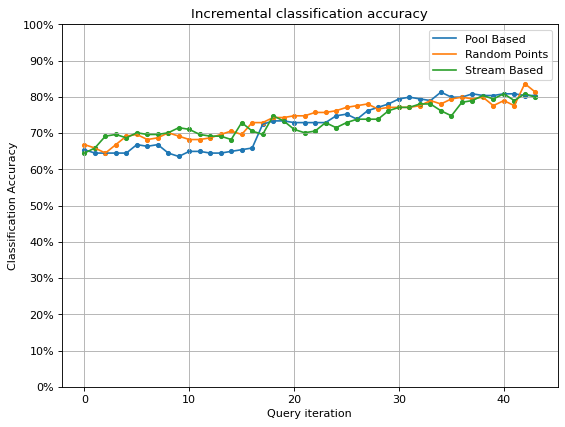

In [61]:
#20% Additional Labels
n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_random = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using KL: %f' % unqueried_score_entropy)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

performance_history_random_20 = [unqueried_score_random]
for i in range(N_QUERIES_20):
    random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
    X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
    committee_entropy.teach(X=X, y=y)
    model_accuracy = committee_entropy.score(X_full, y_full)
    X_remaining = np.delete(X_remaining, random, axis = 0)
    y_remaining = np.delete(y_remaining, random)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
    performance_history_random_20.append(model_accuracy)


n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)

# stream_idx = np.random.choice(range(len(X_stream)))
# KL_max_disagreement(committee_entropy, X_stream[stream_idx].reshape(1, -1))
# stream1 = []

performance_history_stream_20 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if KL_max_disagreement(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.06:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_stream_20.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_20:
            break;
    
    
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_20, label = "Pool Based")
ax.plot(performance_history_random_20, label = "Random Points")
ax.plot(performance_history_stream_20, label = "Stream Based")
leg = ax.legend()
ax.scatter(range(len(performance_history_KL_20)), performance_history_KL_20, s=13)
ax.scatter(range(len(performance_history_random_20)), performance_history_random_20, s=13)
ax.scatter(range(len(performance_history_stream_20)), performance_history_stream_20, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_20.png")
plt.show()


Initial prediction accuracy using KL: 0.682243
Accuracy after query [80]: 0.6589
Accuracy after query [61]: 0.6495
Accuracy after query [159]: 0.6729
Accuracy after query [134]: 0.6682
Accuracy after query [19]: 0.6963
Accuracy after query [84]: 0.6682
Accuracy after query [111]: 0.6542
Accuracy after query [92]: 0.6589
Accuracy after query [121]: 0.6355
Accuracy after query [151]: 0.5981
Accuracy after query [120]: 0.6495
Accuracy after query [167]: 0.6869
Accuracy after query [59]: 0.6776
Accuracy after query [157]: 0.6636
Accuracy after query [65]: 0.6729
Accuracy after query [169]: 0.6869
Accuracy after query [62]: 0.6916
Accuracy after query [168]: 0.6822
Accuracy after query [92]: 0.7056
Accuracy after query [145]: 0.7103
Accuracy after query [168]: 0.7243
Accuracy after query [47]: 0.6916
Accuracy after query [115]: 0.6963
Accuracy after query [73]: 0.7009
Accuracy after query [47]: 0.7243
Accuracy after query [64]: 0.7243
Accuracy after query [105]: 0.7336
Accuracy after query 

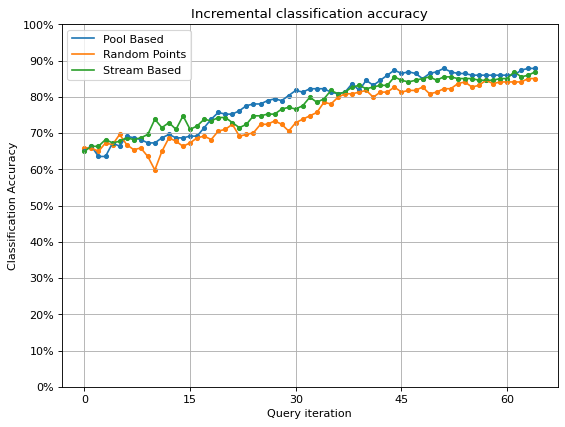

In [64]:
# 30% Additional Labels
n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_random = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using KL: %f' % unqueried_score_entropy)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

performance_history_random_30 = [unqueried_score_random]
for i in range(N_QUERIES_30):
    random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
    X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
    committee_entropy.teach(X=X, y=y)
    model_accuracy = committee_entropy.score(X_full, y_full)
    X_remaining = np.delete(X_remaining, random, axis = 0)
    y_remaining = np.delete(y_remaining, random)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
    performance_history_random_30.append(model_accuracy)


n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_stream_30 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if KL_max_disagreement(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.05:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_stream_30.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_30:
            break;  
    
    
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_30, label = "Pool Based")
ax.plot(performance_history_random_30, label = "Random Points")
ax.plot(performance_history_stream_30, label = "Stream Based")
leg = ax.legend()
ax.scatter(range(len(performance_history_KL_30)), performance_history_KL_30, s=13)
ax.scatter(range(len(performance_history_random_30)), performance_history_random_30, s=13)
ax.scatter(range(len(performance_history_stream_30)), performance_history_stream_30, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_30.png")
plt.show()


Initial prediction accuracy using KL: 0.682243
Accuracy after query [175]: 0.6776
Accuracy after query [68]: 0.6495
Accuracy after query [133]: 0.6729
Accuracy after query [183]: 0.6449
Accuracy after query [132]: 0.6822
Accuracy after query [163]: 0.6869
Accuracy after query [144]: 0.6963
Accuracy after query [19]: 0.6963
Accuracy after query [47]: 0.7150
Accuracy after query [181]: 0.7056
Accuracy after query [134]: 0.7103
Accuracy after query [178]: 0.7243
Accuracy after query [49]: 0.6916
Accuracy after query [97]: 0.7196
Accuracy after query [107]: 0.7430
Accuracy after query [97]: 0.7430
Accuracy after query [32]: 0.7477
Accuracy after query [58]: 0.7477
Accuracy after query [50]: 0.7570
Accuracy after query [42]: 0.7523
Accuracy after query [18]: 0.7383
Accuracy after query [71]: 0.7617
Accuracy after query [27]: 0.7430
Accuracy after query [124]: 0.7477
Accuracy after query [42]: 0.7523
Accuracy after query [39]: 0.7523
Accuracy after query [127]: 0.7477
Accuracy after query [3

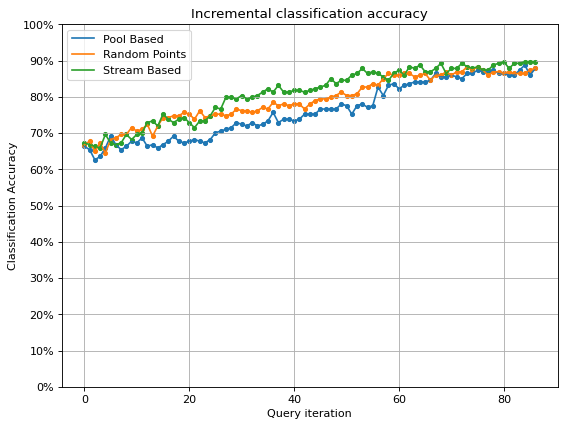

In [65]:
# 40% Additional Labels
n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_random = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using KL: %f' % unqueried_score_entropy)

X_remaining = np.delete(X_full, train_idx, axis=0)
y_remaining = np.delete(y_full, train_idx)

performance_history_random_40 = [unqueried_score_random]
for i in range(N_QUERIES_40):
    random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
    X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
    committee_entropy.teach(X=X, y=y)
    model_accuracy = committee_entropy.score(X_full, y_full)
    X_remaining = np.delete(X_remaining, random, axis = 0)
    y_remaining = np.delete(y_remaining, random)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
    performance_history_random_40.append(model_accuracy)


n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_stream_40 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if KL_max_disagreement(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.045:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_stream_40.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_40:
            break;    
    
    
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_40, label = "Pool Based")
ax.plot(performance_history_random_40, label = "Random Points")
ax.plot(performance_history_stream_40, label = "Stream Based")
leg = ax.legend()
ax.scatter(range(len(performance_history_KL_40)), performance_history_KL_40, s=13)
ax.scatter(range(len(performance_history_random_40)), performance_history_random_40, s=13)
ax.scatter(range(len(performance_history_stream_40)), performance_history_stream_40, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_40.png")
plt.show()


In [ ]:
# # 20% Additional Labels
# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=KL_max_disagreement)

# unqueried_score_random = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using KL: %f' % unqueried_score_entropy)

# X_remaining = np.delete(X_full, train_idx, axis=0)
# y_remaining = np.delete(y_full, train_idx)

# performance_history_random_20 = [unqueried_score_random]
# for i in range(N_QUERIES_20):
#     random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
#     X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
#     committee_entropy.teach(X=X, y=y)
#     model_accuracy = committee_entropy.score(X_full, y_full)
#     X_remaining = np.delete(X_remaining, random, axis = 0)
#     y_remaining = np.delete(y_remaining, random)
#     print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
#     performance_history_random_20.append(model_accuracy)


# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=KL_max_disagreement)

# unqueried_score_stream = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

# X_stream = np.delete(X_full, train_idx, axis=0)
# y_stream = np.delete(y_full, train_idx)


# stream1 = []

# performance_history_stream_20 = [unqueried_score_stream]
# for index in range(N_QUERIES_20):
#     stream_idx = np.random.choice(range(len(X_stream)))
#     if classifier_uncertainty(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.4:
#         committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
#         new_score = committee_entropy.score(X_full, y_full)
#         X_stream = np.delete(X_stream, stream_idx, axis = 0)
#         y_stream = np.delete(y_stream, stream_idx)
#         performance_history_stream_20.append(new_score)
#         print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
    
    
    
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

# ax.plot(performance_history_KL_20, label = "Pool Based")
# ax.plot(performance_history_random_20, label = "Random Points")
# ax.plot(performance_history_stream_20, label = "Stream Based")
# leg = ax.legend()
# ax.scatter(range(len(performance_history_KL_20)), performance_history_KL_20, s=13)
# ax.scatter(range(len(performance_history_random_20)), performance_history_random_20, s=13)
# ax.scatter(range(len(performance_history_stream_20)), performance_history_stream_20, s=13)
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
# ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

# ax.set_ylim(bottom=0, top=1)
# ax.grid(True)

# ax.set_title('Incremental classification accuracy')
# ax.set_xlabel('Query iteration')
# ax.set_ylabel('Classification Accuracy')

# plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_20.png")
# plt.show()


In [ ]:
# # 30% Additional Labels
# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=KL_max_disagreement)

# unqueried_score_random = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using KL: %f' % unqueried_score_entropy)

# X_remaining = np.delete(X_full, train_idx, axis=0)
# y_remaining = np.delete(y_full, train_idx)

# performance_history_random_30 = [unqueried_score_random]
# for i in range(N_QUERIES_30):
#     random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
#     X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
#     committee_entropy.teach(X=X, y=y)
#     model_accuracy = committee_entropy.score(X_full, y_full)
#     X_remaining = np.delete(X_remaining, random, axis = 0)
#     y_remaining = np.delete(y_remaining, random)
#     print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
#     performance_history_random_30.append(model_accuracy)


# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=KL_max_disagreement)

# unqueried_score_stream = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

# X_stream = np.delete(X_full, train_idx, axis=0)
# y_stream = np.delete(y_full, train_idx)


# stream1 = []

# performance_history_stream_30 = [unqueried_score_stream]
# i = 0
# while(1):
#     stream_idx = np.random.choice(range(len(X_stream)))
#     if KL_max_disagreement(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.06:
#         i = i+1
#         committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
#         new_score = committee_entropy.score(X_full, y_full)
#         X_stream = np.delete(X_stream, stream_idx, axis = 0)
#         y_stream = np.delete(y_stream, stream_idx)
#         performance_history_stream_30.append(new_score)
#         print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
#         if i == N_QUERIES_30:
#             break;  
    
    
    
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

# ax.plot(performance_history_KL_30, label = "Pool Based")
# ax.plot(performance_history_random_30, label = "Random Points")
# ax.plot(performance_history_stream_30, label = "Stream Based")
# leg = ax.legend()
# ax.scatter(range(len(performance_history_KL_30)), performance_history_KL_30, s=13)
# ax.scatter(range(len(performance_history_random_30)), performance_history_random_30, s=13)
# ax.scatter(range(len(performance_history_stream_30)), performance_history_stream_30, s=13)
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
# ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

# ax.set_ylim(bottom=0, top=1)
# ax.grid(True)

# ax.set_title('Incremental classification accuracy')
# ax.set_xlabel('Query iteration')
# ax.set_ylabel('Classification Accuracy')

# plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_30.png")
# plt.show()


In [ ]:
# # 30% Additional Labels
# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=KL_max_disagreement)

# unqueried_score_random = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using KL: %f' % unqueried_score_entropy)

# X_remaining = np.delete(X_full, train_idx, axis=0)
# y_remaining = np.delete(y_full, train_idx)

# performance_history_random_30 = [unqueried_score_random]
# for i in range(N_QUERIES_30):
#     random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
#     X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
#     committee_entropy.teach(X=X, y=y)
#     model_accuracy = committee_entropy.score(X_full, y_full)
#     X_remaining = np.delete(X_remaining, random, axis = 0)
#     y_remaining = np.delete(y_remaining, random)
#     print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
#     performance_history_random_30.append(model_accuracy)


# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=KL_max_disagreement)

# unqueried_score_stream = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

# X_stream = np.delete(X_full, train_idx, axis=0)
# y_stream = np.delete(y_full, train_idx)


# stream1 = []

# performance_history_stream_30 = [unqueried_score_stream]
# for index in range(N_QUERIES_30):
#     stream_idx = np.random.choice(range(len(X_stream)))
#     if classifier_uncertainty(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.4:
#         committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
#         new_score = committee_entropy.score(X_full, y_full)
#         X_stream = np.delete(X_stream, stream_idx, axis = 0)
#         y_stream = np.delete(y_stream, stream_idx)
#         performance_history_stream_30.append(new_score)
#         print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
    
    
    
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

# ax.plot(performance_history_KL_30, label = "Pool Based")
# ax.plot(performance_history_random_30, label = "Random Points")
# ax.plot(performance_history_stream_30, label = "Stream Based")
# leg = ax.legend()
# ax.scatter(range(len(performance_history_KL_30)), performance_history_KL_30, s=13)
# ax.scatter(range(len(performance_history_random_30)), performance_history_random_30, s=13)
# ax.scatter(range(len(performance_history_stream_30)), performance_history_stream_30, s=13)
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
# ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

# ax.set_ylim(bottom=0, top=1)
# ax.grid(True)

# ax.set_title('Incremental classification accuracy')
# ax.set_xlabel('Query iteration')
# ax.set_ylabel('Classification Accuracy')

# plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_30.png")
# plt.show()


In [ ]:
# # 40% Additional Labels
# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=KL_max_disagreement)

# unqueried_score_random = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using KL: %f' % unqueried_score_entropy)

# X_remaining = np.delete(X_full, train_idx, axis=0)
# y_remaining = np.delete(y_full, train_idx)

# performance_history_random_40 = [unqueried_score_random]
# for i in range(N_QUERIES_40):
#     random = np.random.randint(low=0, high=X_remaining.shape[0], size=1)
#     X, y = X_remaining[random].reshape(1,-1), y_remaining[random].reshape(1,)
#     committee_entropy.teach(X=X, y=y)
#     model_accuracy = committee_entropy.score(X_full, y_full)
#     X_remaining = np.delete(X_remaining, random, axis = 0)
#     y_remaining = np.delete(y_remaining, random)
#     print('Accuracy after query {n}: {acc:0.4f}'.format(n=random + 1, acc=model_accuracy))
#     performance_history_random_40.append(model_accuracy)


# n_members = 5
# learner_list = list()

# for member_idx in range(n_members):
#     X_train = X_full[train_idx]
#     y_train = y_full[train_idx]

#     # initializing learner
#     learner = ActiveLearner(
#         estimator=RandomForestClassifier(),
#         X_training=X_train, y_training = y_train
#     )
#     learner_list.append(learner)

# committee_entropy = Committee(learner_list=learner_list,
#                      query_strategy=KL_max_disagreement)

# unqueried_score_stream = committee_entropy.score(X_full, y_full)
# print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

# X_stream = np.delete(X_full, train_idx, axis=0)
# y_stream = np.delete(y_full, train_idx)


# stream1 = []

# performance_history_stream_40 = [unqueried_score_stream]
# for index in range(N_QUERIES_40):
#     stream_idx = np.random.choice(range(len(X_stream)))
#     if classifier_uncertainty(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.4:
#         committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
#         new_score = committee_entropy.score(X_full, y_full)
#         X_stream = np.delete(X_stream, stream_idx, axis = 0)
#         y_stream = np.delete(y_stream, stream_idx)
#         performance_history_stream_40.append(new_score)
#         print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
    
    
    
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

# ax.plot(performance_history_KL_40, label = "Pool Based")
# ax.plot(performance_history_random_40, label = "Random Points")
# ax.plot(performance_history_stream_40, label = "Stream Based")
# leg = ax.legend()
# ax.scatter(range(len(performance_history_KL_40)), performance_history_KL_40, s=13)
# ax.scatter(range(len(performance_history_random_40)), performance_history_random_40, s=13)
# ax.scatter(range(len(performance_history_stream_40)), performance_history_stream_40, s=13)
# ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
# ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
# ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

# ax.set_ylim(bottom=0, top=1)
# ax.grid(True)

# ax.set_title('Incremental classification accuracy')
# ax.set_xlabel('Query iteration')
# ax.set_ylabel('Classification Accuracy')

# plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/part4_qbc_40.png")
# plt.show()


# Stream Based

Initial prediction accuracy using vote entropy: 0.682243
Row no. 169 queried, new accuracy: 0.658879
Row no. 180 queried, new accuracy: 0.672897
Row no. 17 queried, new accuracy: 0.658879
Row no. 153 queried, new accuracy: 0.682243
Row no. 161 queried, new accuracy: 0.700935
Row no. 181 queried, new accuracy: 0.700935
Row no. 147 queried, new accuracy: 0.710280
Row no. 51 queried, new accuracy: 0.719626
Row no. 52 queried, new accuracy: 0.719626
Row no. 178 queried, new accuracy: 0.719626
Row no. 144 queried, new accuracy: 0.724299
Row no. 170 queried, new accuracy: 0.710280
Row no. 78 queried, new accuracy: 0.728972
Row no. 143 queried, new accuracy: 0.714953
Row no. 17 queried, new accuracy: 0.705607
Row no. 151 queried, new accuracy: 0.724299
Row no. 107 queried, new accuracy: 0.742991
Row no. 160 queried, new accuracy: 0.738318
Row no. 147 queried, new accuracy: 0.747664
Row no. 67 queried, new accuracy: 0.757009
Row no. 138 queried, new accuracy: 0.752336
Initial prediction accura

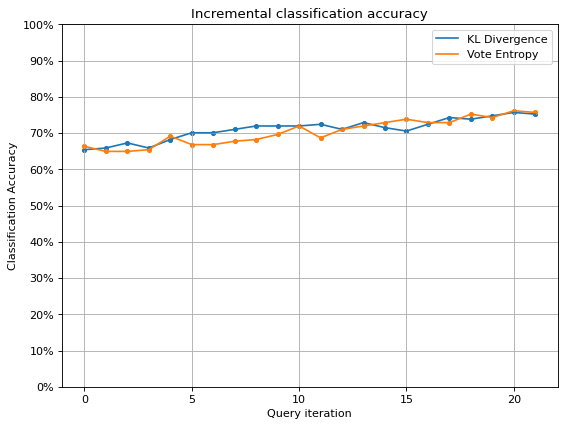

In [71]:
# 10% Additional Labels
n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_KL_10 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if KL_max_disagreement(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.065:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_KL_10.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_10:
            break
    

n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=vote_entropy)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_entropy_10 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if vote_entropy(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.48:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_entropy_10.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_10:
            break    
    
    
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_10, label = "KL Divergence")
ax.plot(performance_history_entropy_10, label = "Vote Entropy")
#ax.plot(performance_history_stream_20, label = "Stream Based")
leg = ax.legend()
ax.scatter(range(len(performance_history_KL_10)), performance_history_KL_10, s=13)
ax.scatter(range(len(performance_history_entropy_10)), performance_history_entropy_10, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/Streambased_qbc_10.png")
plt.show()


Initial prediction accuracy using vote entropy: 0.682243
Row no. 186 queried, new accuracy: 0.668224
Row no. 64 queried, new accuracy: 0.677570
Row no. 82 queried, new accuracy: 0.654206
Row no. 68 queried, new accuracy: 0.686916
Row no. 114 queried, new accuracy: 0.663551
Row no. 11 queried, new accuracy: 0.686916
Row no. 48 queried, new accuracy: 0.691589
Row no. 88 queried, new accuracy: 0.691589
Row no. 129 queried, new accuracy: 0.700935
Row no. 173 queried, new accuracy: 0.710280
Row no. 163 queried, new accuracy: 0.710280
Row no. 2 queried, new accuracy: 0.710280
Row no. 151 queried, new accuracy: 0.728972
Row no. 73 queried, new accuracy: 0.728972
Row no. 61 queried, new accuracy: 0.719626
Row no. 177 queried, new accuracy: 0.733645
Row no. 158 queried, new accuracy: 0.724299
Row no. 89 queried, new accuracy: 0.747664
Row no. 70 queried, new accuracy: 0.733645
Row no. 52 queried, new accuracy: 0.761682
Row no. 112 queried, new accuracy: 0.761682
Row no. 121 queried, new accurac

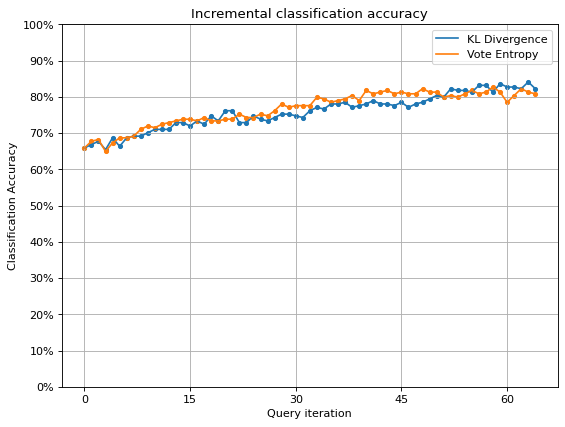

In [75]:
# 30% Additional Labels
n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_KL_30 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if KL_max_disagreement(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.05:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_KL_30.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_30:
            break
    

n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=vote_entropy)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_entropy_30 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if vote_entropy(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_entropy_30.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_30:
            break    
    
    
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_30, label = "KL Divergence")
ax.plot(performance_history_entropy_30, label = "Vote Entropy")
leg = ax.legend()
ax.scatter(range(len(performance_history_KL_30)), performance_history_KL_30, s=13)
ax.scatter(range(len(performance_history_entropy_30)), performance_history_entropy_30, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/Streambased_qbc_30.png")
plt.show()


Initial prediction accuracy using vote entropy: 0.682243
Row no. 100 queried, new accuracy: 0.658879
Row no. 113 queried, new accuracy: 0.668224
Row no. 150 queried, new accuracy: 0.677570
Row no. 181 queried, new accuracy: 0.686916
Row no. 105 queried, new accuracy: 0.700935
Row no. 148 queried, new accuracy: 0.691589
Row no. 9 queried, new accuracy: 0.686916
Row no. 45 queried, new accuracy: 0.724299
Row no. 170 queried, new accuracy: 0.714953
Row no. 12 queried, new accuracy: 0.724299
Row no. 15 queried, new accuracy: 0.714953
Row no. 47 queried, new accuracy: 0.710280
Row no. 103 queried, new accuracy: 0.714953
Row no. 152 queried, new accuracy: 0.719626
Row no. 147 queried, new accuracy: 0.733645
Row no. 163 queried, new accuracy: 0.747664
Row no. 147 queried, new accuracy: 0.757009
Row no. 172 queried, new accuracy: 0.747664
Row no. 53 queried, new accuracy: 0.747664
Row no. 144 queried, new accuracy: 0.747664
Row no. 20 queried, new accuracy: 0.747664
Row no. 55 queried, new acc

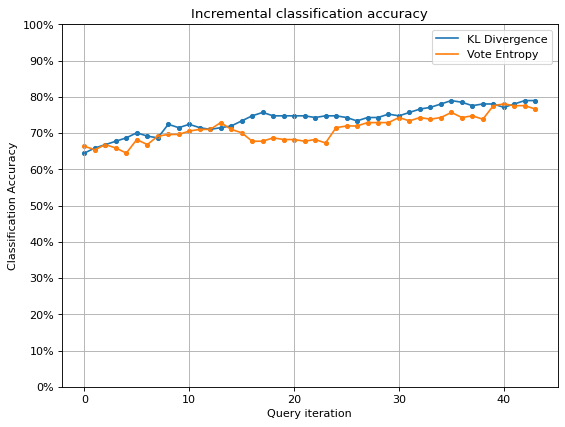

In [74]:
# 20% Additional Labels
n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_KL_20 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if KL_max_disagreement(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.05:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_KL_20.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_20:
            break
    

n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=vote_entropy)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_entropy_20 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if vote_entropy(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_entropy_20.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_20:
            break    
    
    
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_20, label = "KL Divergence")
ax.plot(performance_history_entropy_20, label = "Vote Entropy")
#ax.plot(performance_history_stream_20, label = "Stream Based")
leg = ax.legend()
ax.scatter(range(len(performance_history_KL_20)), performance_history_KL_20, s=13)
ax.scatter(range(len(performance_history_entropy_20)), performance_history_entropy_20, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/Streambased_qbc_20.png")
plt.show()


Initial prediction accuracy using vote entropy: 0.682243
Row no. 176 queried, new accuracy: 0.654206
Row no. 73 queried, new accuracy: 0.672897
Row no. 83 queried, new accuracy: 0.668224
Row no. 87 queried, new accuracy: 0.654206
Row no. 165 queried, new accuracy: 0.663551
Row no. 53 queried, new accuracy: 0.668224
Row no. 157 queried, new accuracy: 0.668224
Row no. 181 queried, new accuracy: 0.677570
Row no. 94 queried, new accuracy: 0.663551
Row no. 76 queried, new accuracy: 0.696262
Row no. 99 queried, new accuracy: 0.696262
Row no. 175 queried, new accuracy: 0.714953
Row no. 5 queried, new accuracy: 0.696262
Row no. 142 queried, new accuracy: 0.719626
Row no. 118 queried, new accuracy: 0.691589
Row no. 171 queried, new accuracy: 0.705607
Row no. 154 queried, new accuracy: 0.691589
Row no. 152 queried, new accuracy: 0.700935
Row no. 115 queried, new accuracy: 0.728972
Row no. 47 queried, new accuracy: 0.738318
Row no. 92 queried, new accuracy: 0.752336
Row no. 136 queried, new accur

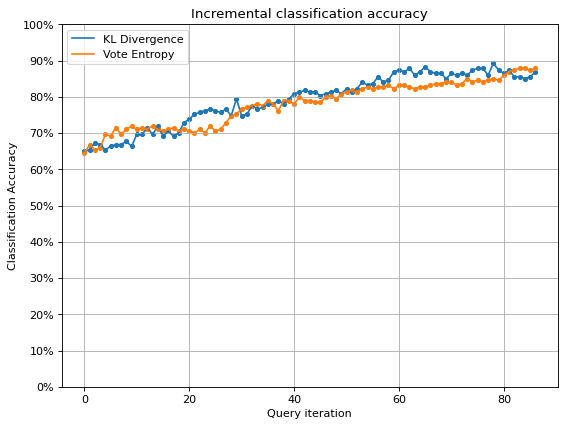

In [76]:
# 40% Additional Labels
n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=KL_max_disagreement)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_KL_40 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if KL_max_disagreement(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0.04:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_KL_40.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_40:
            break
    

n_members = 5
learner_list = list()

for member_idx in range(n_members):
    X_train = X_full[train_idx]
    y_train = y_full[train_idx]

    # initializing learner
    learner = ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training = y_train
    )
    learner_list.append(learner)

committee_entropy = Committee(learner_list=learner_list,
                     query_strategy=vote_entropy)

unqueried_score_stream = committee_entropy.score(X_full, y_full)
print('Initial prediction accuracy using vote entropy: %f' % unqueried_score_entropy)

X_stream = np.delete(X_full, train_idx, axis=0)
y_stream = np.delete(y_full, train_idx)


stream1 = []

performance_history_entropy_40 = [unqueried_score_stream]
i = 0
while(1):
    stream_idx = np.random.choice(range(len(X_stream)))
    if vote_entropy(committee_entropy, X_stream[stream_idx].reshape(1, -1)) >= 0:
        i = i+1
        committee_entropy.teach(X_stream[stream_idx].reshape(1, -1), y_stream[stream_idx].reshape(-1, ))
        new_score = committee_entropy.score(X_full, y_full)
        X_stream = np.delete(X_stream, stream_idx, axis = 0)
        y_stream = np.delete(y_stream, stream_idx)
        performance_history_entropy_40.append(new_score)
        print('Row no. %d queried, new accuracy: %f' % (stream_idx, new_score))    
        if i == N_QUERIES_40:
            break    
    
    
    
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)

ax.plot(performance_history_KL_40, label = "KL Divergence")
ax.plot(performance_history_entropy_40, label = "Vote Entropy")
leg = ax.legend()
ax.scatter(range(len(performance_history_KL_40)), performance_history_KL_40, s=13)
ax.scatter(range(len(performance_history_entropy_40)), performance_history_entropy_40, s=13)
ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=5, integer=True))
ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

ax.set_ylim(bottom=0, top=1)
ax.grid(True)

ax.set_title('Incremental classification accuracy')
ax.set_xlabel('Query iteration')
ax.set_ylabel('Classification Accuracy')

plt.savefig("/Users/MyFolders/3rd year/ML/Assignments/Assignment 2/Snapshots/Streambased_qbc_40.png")
plt.show()
